## Reweighting Study - WS model

In [45]:
import numpy as np
import pandas as pd
from paws.components import ModelTrainer, ModelLoader, MetricLandscape

datadir = "/pscratch/sd/c/chlcheng/projects/paws/datasets"
outdir = "/pscratch/sd/c/chlcheng/projects/paws/outputs"

m1, m2 = 300, 300
mu = 0.003
alpha = 0.5

# declare options to create the weakly datasets
model_options = {
    "mass_point": [m1, m2],
    "mu": mu,
    "alpha": alpha
}

model_trainer = ModelTrainer("semi_weakly", model_options=model_options, decay_modes="qq,qqq",
                             cache_test=True, variables="3,5,6", noise_dimension=10, datadir=datadir, outdir=outdir)
datasets = model_trainer.get_datasets()
ws_model = model_trainer.get_model()
fs2_model = model_trainer.model_loader.fs_2_model
fs3_model = model_trainer.model_loader.fs_3_model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
[INFO] Created MirroredStrategy for distributed training
[INFO] Number of devices : 1
[INFO]      aliad version : 0.1.0
[INFO] tensorflow version : 2.15.0
Sat Oct  5 00:29:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |      3MiB / 40960MiB |      0%      D

In [46]:
prior_ratio_models = {
    'qq': {
    },
    'qqq': {
    }
}
model_options = {
    'sampling_method': 'sampled'
}
qq_prior_trainer = ModelTrainer("prior_ratio", model_options=model_options, decay_modes="qq",
                                cache_test=True, variables="3,5,6", datadir=datadir, outdir=outdir)
qqq_prior_trainer = ModelTrainer("prior_ratio", model_options=model_options, decay_modes="qqq",
                                 cache_test=True, variables="3,5,6", datadir=datadir, outdir=outdir)
prior_ratio_models['qq']['sampled'] = qq_prior_trainer.load_trained_model()
prior_ratio_models['qqq']['sampled'] = qqq_prior_trainer.load_trained_model()

model_options = {
    'sampling_method': 'inferred'
}
qq_prior_trainer = ModelTrainer("prior_ratio", model_options=model_options, decay_modes="qq",
                                cache_test=True, variables="3,5,6", datadir=datadir, outdir=outdir)
qqq_prior_trainer = ModelTrainer("prior_ratio", model_options=model_options, decay_modes="qqq",
                                 cache_test=True, variables="3,5,6", datadir=datadir, outdir=outdir)
prior_ratio_models['qq']['inferred'] = qq_prior_trainer.load_trained_model()
prior_ratio_models['qqq']['inferred'] = qqq_prior_trainer.load_trained_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
[INFO] Created MirroredStrategy for distributed training
[INFO] Number of devices : 1
[INFO]      aliad version : 0.1.0
[INFO] tensorflow version : 2.15.0
Sat Oct  5 00:29:46 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   33C    P0    34W / 250W |      3MiB / 40960MiB |      0%      D

In [3]:
weights = {
    'm1': m1 / 100,
    'm2': m2 / 100,
    'mu': np.log(mu),
    'alpha': alpha
}
ModelLoader.set_model_weights(ws_model, weights)

In [4]:
x = np.concatenate([d[0][0] for d in datasets['train']])
y_true = np.concatenate([d[1] for d in datasets['train']]).flatten()
y_pred_2 = fs2_model.predict(x).flatten()
y_pred_3 = fs3_model.predict(x).flatten()
y_pred = ws_model.predict(x).flatten()
data_mask = y_true == 1
ref_mask = y_true == 0

2024-10-04 19:09:03.943488: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


11488/11488 [==============================] - 12s 1ms/step


In [40]:
from keras.models import Model

In [42]:
prior_ratio_models['qq']['sampled']

In [41]:
isinstance(prior_ratio_models['qq']['sampled'], Model)

True

In [5]:
kappa_2 = prior_ratio_models['qq']['sampled'].predict([[m1, m2]]).flatten()[0]
kappa_3 = prior_ratio_models['qqq']['sampled'].predict([[m1, m2]]).flatten()[0]

1/1 [==============================] - 0s 114ms/step


In [27]:
def get_nll(y_true, y_pred_2, y_pred_3, mu, alpha, kappa_2=1.0, kappa_3=1.0):
    l2 = kappa_2 * (y_pred_2 / (1 - y_pred_2))
    l3 = kappa_3 * (y_pred_3 / (1 - y_pred_3))
    likelihood = mu * (alpha * l3 + (1 - alpha) * l2) + 1 - mu
    nll =  np.mean(- y_true * np.log(likelihood))
    return nll

In [38]:
mu_test = 0.003
get_nll(y_true, y_pred_2, y_pred_3, mu=mu_test, alpha=alpha, kappa_2=kappa_2, kappa_3=kappa_3).min()

-0.0009066277261685631

In [17]:
nll.min()

-4.903601169586182

In [18]:
mu

0.003

In [1]:
def get_bce(y_true, y_pred_2, y_pred_3, mu, alpha, kappa=1.0, nu=1.0, vectorize: bool = False):
    L2 = kappa * y_pred_2 / (1 - y_pred_2)
    L3 = nu * y_pred_3 / (1 - y_pred_3)
    ws = (mu * (alpha * L3  + (1 - alpha) * L2 ) + 1 - mu) / (mu * (alpha * L3 + (1 - alpha) * L2) +2 - 2 *mu)
    axis = 1 if vectorize else None
    return (np.mean(-(y_true * np.log(ws) + (1 - y_true) * np.log(1 - ws)), axis=axis) - np.log(2)) * 1e5

In [112]:
import numpy as np

alpha_list = np.arange(0, 1, 0.02)
mu_list = np.exp(np.arange(-8, -2, 0.1))

alpha_grid, mu_grid = np.meshgrid(alpha_list, mu_list)
mu_all = mu_grid.reshape(-1, 1)
alpha_all = alpha_grid.reshape(-1, 1)

In [114]:
from quickstats.maths.numerics import get_nbatch
results = {
    'mu': np.array([]),
    'alpha': np.array([]),
    'loss': np.array([])
}
batchsize = 500
nbatch = get_nbatch(mu_all.shape[0], batchsize)
y_pred_2_all = None
y_pred_3_all = None
y_true_all = None
for i in range(nbatch):
    print(f'batch {i+1} / {nbatch}')
    mu_sub = mu_all[i * batchsize : (i + 1) * batchsize]
    alpha_sub = alpha_all[i * batchsize : (i + 1) * batchsize]
    if (y_pred_2_all is None) or (y_pred_2_all.shape[0] != mu_sub.shape[0]):
        y_pred_2_all = np.tile(y_pred_2, (mu_sub.shape[0], 1))
        y_pred_3_all = np.tile(y_pred_3, (mu_sub.shape[0], 1))
        y_true_all = np.tile(y_true, (mu_sub.shape[0], 1))
    losses = get_bce_vectorized(y_true_all, y_pred_2_all, y_pred_3_all, mu_sub, alpha_sub, kappa=7.2, nu=7.76)
    results['mu'] = np.concatenate([results['mu'], mu_sub.flatten()])
    results['alpha'] = np.concatenate([results['alpha'], alpha_sub.flatten()])
    results['loss'] = np.concatenate([results['loss'], losses.flatten()])

batch 1 / 6
batch 2 / 6
batch 3 / 6
batch 4 / 6
batch 5 / 6
batch 6 / 6


In [14]:
import pandas as pd
from quickstats.plots import VariableDistributionPlot

df_data = pd.DataFrame({
    'm1': x_data[:, 0, 0] * 1000,
    'm2': x_data[:, 1, 0] * 1000,
    'y_pred': y_data,
    'tau12_j1': x_data[:, 0, 1],
    'weight': np.ones(y_data.shape)
})

df_ref = pd.DataFrame({
    'm1': x_ref[:, 0, 0] * 1000,
    'm2': x_ref[:, 1, 0] * 1000,
    'y_pred': y_ref,
    'tau12_j1': x_ref[:, 0, 1],
    'weight': np.ones(y_ref.shape)
})

df_ref_rw = pd.DataFrame({
    'm1': x_ref[:, 0, 0] * 1000,
    'm2': x_ref[:, 1, 0] * 1000,
    'y_pred': y_ref,
    'tau12_j1': x_ref[:, 0, 1],
    'weight': reweight_factor
})

analysis_label_options = {
    'extra_text': r'$(m_X, m_Y) = (300, 300) GeV$//'
}

dfs = {
    'Data': df_data,
    'Reference': df_ref,
    'Reference Reweighted': df_ref_rw
}

plotter = VariableDistributionPlot(dfs, analysis_label_options=analysis_label_options)

<Axes: xlabel='$m_X$ [GeV]', ylabel='Fraction of Events / 25.00'>

<Figure size 640x480 with 0 Axes>

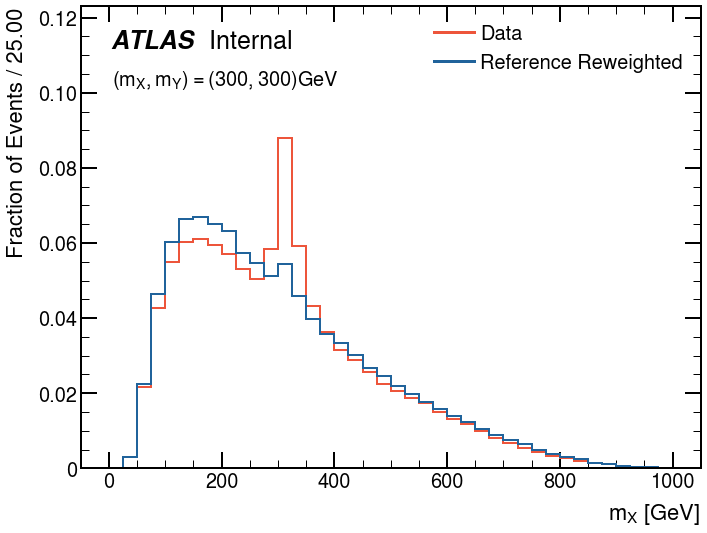

In [15]:
plotter.draw('m1', weight_name='weight', xlabel='$m_X$ [GeV]',
             #targets=['Data', 'Reference', 'Reference Reweighted'],
             targets=['Data', 'Reference Reweighted'],
             #targets=['Reference', 'Reference Reweighted'],
             bin_range=(0, 1000), bins = 40, ypad=0.25, normalize=True)

<Axes: xlabel='$m_Y$ [GeV]', ylabel='Fraction of Events / 25.00'>

<Figure size 640x480 with 0 Axes>

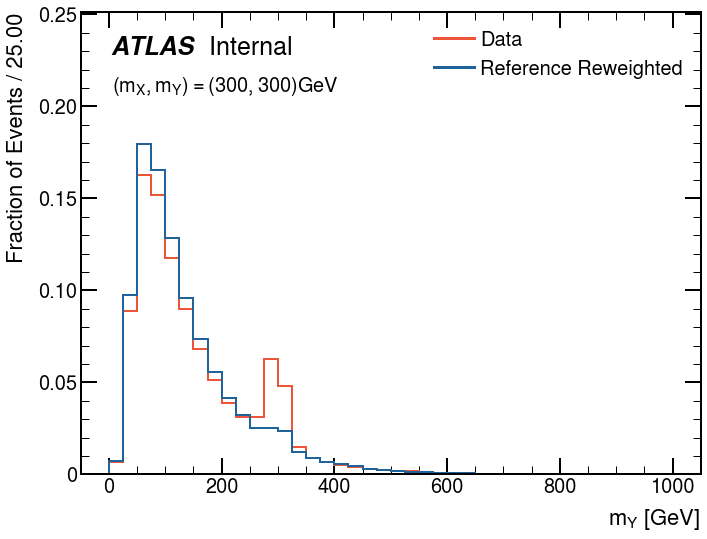

In [16]:
plotter.draw('m2', weight_name='weight', xlabel='$m_Y$ [GeV]',
             #targets=['Data', 'Reference', 'Reference Reweighted'],
             targets=['Data', 'Reference Reweighted'],
             #targets=['Reference', 'Reference Reweighted'],
             bin_range=(0, 1000), bins = 40, ypad=0.25, normalize=True)

## It does something, but clearly something is off!

- Some scaling is off...

In [390]:
import numpy as np
import pandas as pd
from paws.components import ModelTrainer, ModelLoader, MetricLandscape

datadir = "/pscratch/sd/c/chlcheng/projects/paws/datasets"
outdir = "/pscratch/sd/c/chlcheng/projects/paws/outputs"

m1, m2 = 300, 300
mu = 0.1
alpha = 0

# declare options to create the weakly datasets
model_options = {
    "mass_point": [m1, m2],
    "mu": mu,
    "alpha": alpha
}

model_trainer = ModelTrainer("semi_weakly", model_options=model_options, decay_modes="qq,qqq",
                             cache_test=True, variables="3,5,6", datadir=datadir, outdir=outdir)
datasets = model_trainer.get_datasets()
ws_model = model_trainer.get_model()
fs2_model = model_trainer.model_loader.fs_2_model
fs3_model = model_trainer.model_loader.fs_3_model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
[INFO] Created MirroredStrategy for distributed training
[INFO] Number of devices : 1
[INFO]      aliad version : 0.1.0
[INFO] tensorflow version : 2.15.0
Sat Sep 28 04:27:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:C3:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |      2MiB / 40960MiB |      0%      D

In [391]:
weights = {
    'm1': 3.0,
    'm2': 3.0
}
ModelLoader.set_model_weights(fs2_model, weights)
ModelLoader.set_model_weights(fs3_model, weights)

In [403]:
y2_pred = fs2_model.predict(datasets['val']).flatten()
y3_pred = fs3_model.predict(datasets['val']).flatten()

2024-09-28 04:29:44.721292: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


190/190 [==============================] - 1s 2ms/step


In [404]:
x = np.concatenate([d[0][0] for d in datasets['val']])
y_true = np.concatenate([d[1] for d in datasets['val']]).flatten()
l2 = y2_pred / (1 - y2_pred)
l3 = y3_pred / (1 - y3_pred)

In [405]:
ref_mask = y_true == 0
l2[ref_mask].shape[0] / l2[ref_mask].sum()

7.056085473703082

In [395]:
from sklearn.metrics import log_loss
def get_loss(mu, kappa, y_true):
    ws = (mu * l2 * kappa + 1 - mu) / (mu * l2 * kappa + 2 - 2 * mu)
    return log_loss(y_true, ws) - np.log(2)

In [399]:
mu_list = np.arange(0.01, 0.2, 0.0002)
kappa_list = [10.81]
results = []
for mu in mu_list:
    for kappa in kappa_list:
        losses = get_loss(mu, kappa, y_true)
        results.append({
            'mu': mu,
            'kappa': kappa,
            'loss': losses
        })

In [400]:
import pandas as pd
df = pd.DataFrame(results)
df['loss'].argmin()

344

In [401]:
df.loc[df['loss'].argmin()]

mu        0.078800
kappa    10.810000
loss     -0.027121
Name: 344, dtype: float64

In [329]:
mu_list[np.argmin(losses)]

0.0001

In [388]:
np.log(0.003560)

-5.637994734118198

In [389]:
np.log(0.003)

-5.809142990314028

In [740]:
data_mask = y_true == 1
ref_mask = y_true == 0
l2_norm = (l2 / l2[ref_mask].sum()) * l2[ref_mask].shape[0]
l3_norm = (l3 / l3[ref_mask].sum()) * l3[ref_mask].shape[0]

In [741]:
import matplotlib.pyplot as plt
ws = (mu * l2 + (1 - mu)) / (mu * l2 + (2 - mu))
ws_norm = (mu * l2_norm + (1 - mu)) / (mu * l2_norm + (2 - mu))

In [702]:
sf2_ref = l2[ref_mask].shape[0] / l2[ref_mask].sum()
sf3_ref = l3[ref_mask].shape[0] / l3[ref_mask].sum()

sf2_data = l2[data_mask].shape[0] / l2[data_mask].sum()
sf3_data = l3[data_mask].shape[0] / l3[data_mask].sum()

In [684]:
ws_orig = (mu * (alpha * l2 + (1-alpha) * l3) + (1 - mu)) / (mu * (alpha * l2 + (1-alpha) * l3) + (2 - mu))
ws = (mu * (alpha * l3_norm + (1 - alpha) * l2_norm) + (1 - mu)) / (mu * (alpha * l3_norm + (1 - alpha) * l2_norm)+ (2 - mu))

In [685]:
from sklearn.metrics import log_loss

In [690]:
def get_loss(mu, alpha):
    A = l3 * (y_true * sf3_data + (1 - y_true) *sf3_ref)
    B = l2 * (y_true * sf2_data + (1 - y_true) *sf2_ref)
    C = mu * (alpha * A + (1 - alpha) * B)
    ws_ = (C + (1 - mu)) / (C + (2 - mu))
    return log_loss(y_true, ws_) - np.log(2)

def get_loss_orig(mu, alpha):
    ws_ = (mu * (alpha * l3 + (1 - alpha) * l2) + (1 - mu)) / (mu * (alpha * l3 + (1 - alpha) * l2)+ (2 - mu))
    return log_loss(y_true, ws_) - np.log(2)

def get_loss(mu, alpha, kappa):
    A = mu * l2 * kappa
    ws_ = (A + (1 - mu)) / (A + (2 - mu))
    return log_loss(y_true, ws_) - np.log(2)

#def get_loss(mu, alpha=0):
#    ws_ = (mu  * l2_norm + (1 - mu)) / (mu  * l2_norm+ (2 - mu))
#    return log_loss(y_true, ws_) - np.log(2)

In [479]:
data_mask = y_true == 1
ref_mask = y_true == 0
x_data, x_ref = x[data_mask], x[ref_mask]
y2_data, y2_ref = y2_pred[data_mask], y2_pred[ref_mask]
y3_data, y3_ref = y3_pred[data_mask], y3_pred[ref_mask]
l2_data, l2_ref = l2[data_mask], l2[ref_mask]
l3_data, l3_ref = l3[data_mask], l3[ref_mask]

In [509]:
import pandas as pd
from quickstats.plots import VariableDistributionPlot

df_data = pd.DataFrame({
    'm1': x_data[:, 0, 0] * 1000,
    'm2': x_data[:, 1, 0] * 1000,
    'y_pred': y_data,
    'tau12_j1': x_data[:, 0, 1],
    'weight': np.ones(y_data.shape)
})

df_ref = pd.DataFrame({
    'm1': x_ref[:, 0, 0] * 1000,
    'm2': x_ref[:, 1, 0] * 1000,
    'y_pred': y_ref,
    'tau12_j1': x_ref[:, 0, 1],
    'weight': np.ones(y_ref.shape)
})

df_ref_rw = pd.DataFrame({
    'm1': x_ref[:, 0, 0] * 1000,
    'm2': x_ref[:, 1, 0] * 1000,
    'y_pred': y_ref,
    'tau12_j1': x_ref[:, 0, 1],
    'weight': ws[ref_mask] / (1 - ws[ref_mask])
    #'weight': mu * (alpha * l2_ref / l2_ref.sum() + (1 - alpha) * l3_ref / l3_ref.sum()) * y_ref.shape[0] + (1 - mu)
    #np.concatenate([mu * l_bkg[:nb], np.ones(nb) * (1 - mu)])
})

df_data_rw = pd.DataFrame({
    'm1': x_data[:, 0, 0] * 1000,
    'm2': x_data[:, 1, 0] * 1000,
    'y_pred': y_data,
    'tau12_j1': x_data[:, 0, 1],
    'weight': 1 / (mu * (alpha * l2_data / l2_data.sum() + alpha * l3_data / l3_data.sum()) * y_data.shape[0] + (1 - mu))
})

analysis_label_options = {
    'extra_text': r'$(m_X, m_Y) = (300, 300) GeV$//'
}

dfs = {
    'Data': df_data,
    'Reference': df_ref,
    'Reference Reweighted': df_ref_rw,
    'Data Reweighted': df_data_rw
}

plotter = VariableDistributionPlot(dfs, analysis_label_options=analysis_label_options)

<Axes: xlabel='$m_X$ [GeV]', ylabel='Fraction of Events / 25.00'>

<Figure size 640x480 with 0 Axes>

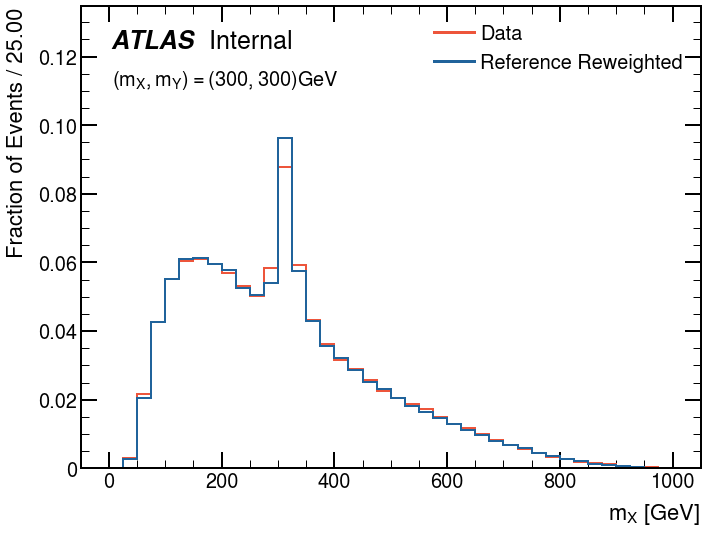

In [510]:
plotter.draw('m1', weight_name='weight', xlabel='$m_X$ [GeV]',
             #targets=['Data', 'Reference', 'Reference Reweighted'],
             targets=['Data', 'Reference Reweighted'],
             #targets=['Reference', 'Reference Reweighted'],
             bin_range=(0, 1000), bins = 40, ypad=0.25, normalize=True)

<Axes: xlabel='$m_X$ [GeV]', ylabel='Fraction of Events / 25.00'>

<Figure size 640x480 with 0 Axes>

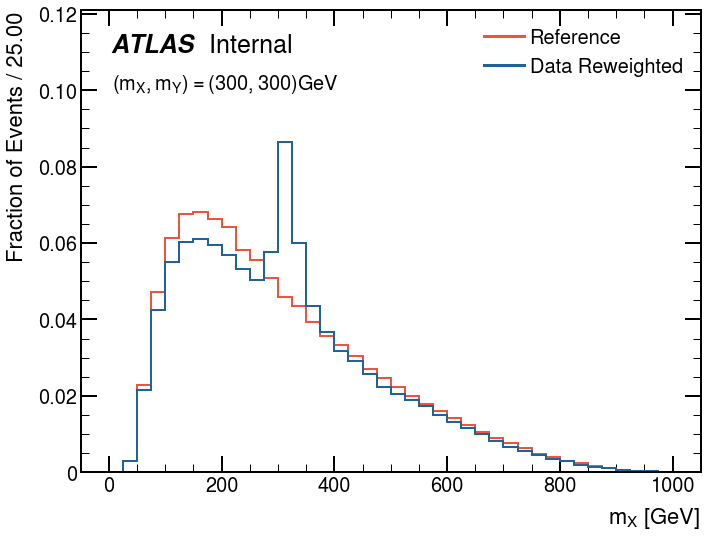

In [370]:
plotter.draw('m1', weight_name='weight', xlabel='$m_X$ [GeV]',
             #targets=['Data', 'Reference', 'Reference Reweighted'],
             targets=['Reference', 'Data Reweighted'],
             #targets=['Reference', 'Reference Reweighted'],
             bin_range=(0, 1000), bins = 40, ypad=0.25, normalize=True)

$$\dfrac{P_D(\vec{x})}{P_R(\vec{x})} = (1 - \mu) \dfrac{WS}{1 - WS}$$

$$\Lambda_{FS} = \dfrac{N_B}{N_S} \dfrac{FS}{1 - FS} = \kappa(\theta) \dfrac{FS}{1 - FS}$$

$$WS = \dfrac{\mu \kappa(\theta) \frac{FS}{1 - FS} + 1 - \mu}{\mu \kappa(\theta) \frac{FS}{1 - FS} + 2 (1 - \mu)}$$

$$WS = \dfrac{\mu (\alpha \kappa_3(\theta) \frac{FS_3}{1 - FS_3} + (1 - \alpha)\kappa_2(\theta)\frac{FS_2}{1 - FS_2}) + 1 - \mu}{\mu (\alpha \kappa_3(\theta) \frac{FS_3}{1 - FS_3} + (1 - \alpha)\kappa_2(\theta)\frac{FS_2}{1 - FS_2}) + 2 (1 - \mu)}$$

In [1]:
from paws.components import ModelLoader

In [2]:
model = ModelLoader.get_single_parameter_model(name='test', trainable=False)

2024-09-29 19:06:36.568957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 19:06:36.568990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 19:06:36.570541: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 19:06:36.579311: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-29 19:06:37.771804: W tensorflow/compiler/tf2

In [3]:
model.get_layer(name='test').weights

[<tf.Variable 'test/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.6027085]], dtype=float32)>]

In [4]:
weight = model.layers[1].weights[0]

In [5]:
from aliad.interface.tensorflow import utils

In [6]:
utils.assign_weight(weight, 1.0)

In [4]:
model.trainable_weights

[]

In [7]:
model.layers[1].trainable

False

In [17]:
weight

<tf.Variable 'test/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>

In [16]:
weight.assign(np.array(1.0).reshape(weight.shape))

<tf.Variable 'UnreadVariable' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>

In [19]:
from numbers import Number

In [21]:
isinstance(np.array(1.0), Number)

False

In [23]:
np.array(1.0).reshape(2)

ValueError: cannot reshape array of size 1 into shape (2,)